# Importing Modules

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import date
print('modules imported')

modules imported


# Importing and Filtering Dataset

Quellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0   Haftungsausschluss: „Die Inhalte, die über die Internetseiten des Robert Koch-Instituts zur Verfügung gestellt werden, dienen ausschließlich der allgemeinen Information der Öffentlichkeit, vorrangig der Fachöffentlichkeit“. 

In [2]:
# data has been downloaded from:
# https://npgeo-corona-npgeo-de.hub.arcgis.com/
# then choose Robert-Koch-Institut and on the next page RKI COVID 19
# this data needs to be filtered for Landkreis=Region Hannover
# and can then be downloaded
# if the data does not seem up to date the full csv-file needs to be downloaded and filtered manually
df_reg_all = pd.read_csv("RKI_COVID19 20210225.csv")
df_reg_han = df_reg_all[df_reg_all['Landkreis']=='Region Hannover'].copy()
print('dataset loaded and filtered')
print(df_reg_han['Landkreis'].value_counts())

dataset loaded and filtered
Region Hannover    11771
Name: Landkreis, dtype: int64


# Dealing with Columns

In [3]:
print(df_reg_han.columns)

Index(['FID', 'IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe',
       'Geschlecht', 'AnzahlFall', 'AnzahlTodesfall', 'Meldedatum',
       'IdLandkreis', 'Datenstand', 'NeuerFall', 'NeuerTodesfall', 'Refdatum',
       'NeuGenesen', 'AnzahlGenesen', 'IstErkrankungsbeginn', 'Altersgruppe2'],
      dtype='object')


In [4]:
strDatenstand = df_reg_han['Datenstand'].describe(include='all').loc['top']
df_reg_han.drop(columns=['FID', 'IdBundesland', 'IdLandkreis', 'Datenstand',
                         'Bundesland', 'Landkreis', 'Refdatum', 'NeuGenesen', 
                         'AnzahlGenesen', 'NeuerTodesfall', 'NeuerFall',
                         'IstErkrankungsbeginn', 'Altersgruppe2'], 
                inplace=True)
print('Datenstand:', strDatenstand)
print('unnecessary columns dropped')

Datenstand: 25.02.2021, 00:00 Uhr
unnecessary columns dropped


# Creating and Working with Pivot Table

In [5]:
piv_reg_han = pd.pivot_table(df_reg_han, 
                             values=['AnzahlFall', 'AnzahlTodesfall'], 
                             index=['Meldedatum'], 
                             aggfunc=np.sum)
display(piv_reg_han.head(2))
display(piv_reg_han.tail(2))

,AnzahlFall,AnzahlTodesfall
Meldedatum,,
2020/03/01 00:00:00,1,0
2020/03/03 00:00:00,1,0


,AnzahlFall,AnzahlTodesfall
Meldedatum,,
2021/02/23 00:00:00,250,0
2021/02/24 00:00:00,231,0


In [6]:
piv_reg_han[['AnzahlFälle', 'AnzahlTodesfälle']] = piv_reg_han.cumsum()
piv_reg_han.reset_index(inplace=True)
piv_reg_han['Meldedatum'] = pd.to_datetime(piv_reg_han['Meldedatum'])
piv_reg_han['Jahr'] = piv_reg_han['Meldedatum'].dt.strftime('%Y')
piv_reg_han['JahrMonat'] = piv_reg_han['Meldedatum'].dt.strftime('%Y-%b')
piv_reg_han['Monat'] = piv_reg_han['Meldedatum'].dt.strftime('%b')
piv_reg_han['KaWo'] = piv_reg_han['Meldedatum'].dt.week
piv_reg_han['WoTag'] = piv_reg_han['Meldedatum'].dt.strftime('%a')
display(piv_reg_han.head(2))
display(piv_reg_han.tail(2))

,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
0,2020-03-01,1,0,1,0,2020,2020-Mar,Mar,9,Sun
1,2020-03-03,1,0,2,0,2020,2020-Mar,Mar,10,Tue


,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
348,2021-02-23,250,0,30666,746,2021,2021-Feb,Feb,8,Tue
349,2021-02-24,231,0,30897,746,2021,2021-Feb,Feb,8,Wed


In [7]:
countdays = piv_reg_han['JahrMonat'].value_counts()
medians = piv_reg_han.groupby(['JahrMonat'])['AnzahlFall'].median()
means = piv_reg_han.groupby(['JahrMonat'])['AnzahlFall'].mean().round(1)
# concat all three series into one dataframe
df_medians_means = pd.concat([countdays, medians, means], axis=1)
# name columns, set and sort indexes
df_medians_means.columns = ['Anzahl gemeldeter Tage', 'Median-/Zentralwert', 'Mittelwert']
cats = ['2020-Mar', '2020-Apr','2020-May','2020-Jun', '2020-Jul', '2020-Aug','2020-Sep', '2020-Oct',
        '2020-Nov', '2020-Dec', '2021-Jan', '2021-Feb']
df_medians_means.index = pd.CategoricalIndex(df_medians_means.index, categories=cats, ordered=True)
df_medians_means.sort_index(ascending=True, inplace=True)
display(df_medians_means)

,Anzahl gemeldeter Tage,Median-/Zentralwert,Mittelwert
2020-Mar,29,24.0,31.0
2020-Apr,30,28.5,35.3
2020-May,31,12.0,15.0
2020-Jun,29,9.0,12.0
2020-Jul,23,4.0,5.5
2020-Aug,31,16.0,16.8
2020-Sep,30,31.0,30.4
2020-Oct,31,65.0,84.9
2020-Nov,30,184.5,183.6
2020-Dec,31,231.0,233.3


# Visualizing Data from Pivot Table

## Line Plot: Cases and Deaths Accumulated, All Dates

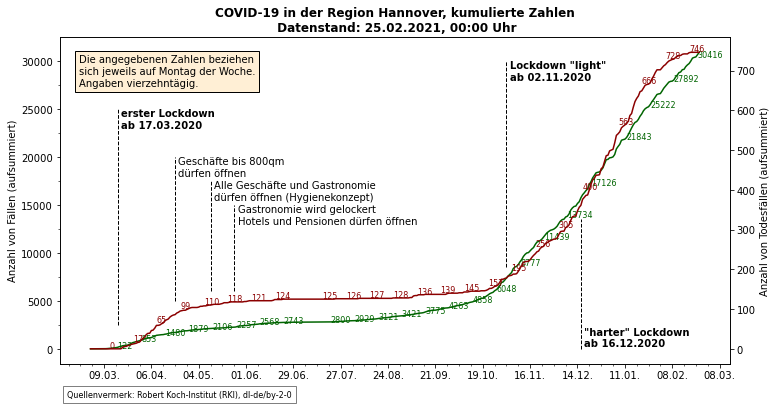

In [8]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(piv_reg_han.Meldedatum, piv_reg_han.AnzahlFälle, color='darkgreen', label='alle Fälle')
# df_top_bottom = piv_reg_han.iloc[[0, -1]]
# ax1.plot(df_top_bottom.Meldedatum, df_top_bottom.AnzahlFälle, color='darkblue', label='hypothetischer\nlinearer Anstieg',
#         linestyle='dotted', linewidth=1)
ax2 = ax1.twinx()
ax2.plot(piv_reg_han.Meldedatum, piv_reg_han.AnzahlTodesfälle, color='darkred', label='davon Todesfälle')
# properties for ax1
ax1.autoscale(enable=True, axis='x')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0, interval=4))
ax1.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=0, interval=1))
ax1.set_xlabel('')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5000))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2500))
ax1.set_ylabel('Anzahl von Fällen (aufsummiert)')
ax1.set_title('COVID-19 in der Region Hannover, kumulierte Zahlen\n Datenstand: ' + strDatenstand, weight='bold')
# ax1.grid(ls=':', axis='y', which='major')
# ax1.grid(ls=(0, (1, 10)), axis='y', which='minor')
# properties for ax2
ax2.set_ylabel('Anzahl von Todesfällen (aufsummiert)')
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc='center left')
for index, row in piv_reg_han.iterrows():
    if row['WoTag'] == 'Mon' and row['KaWo'] % 2 == 0:
        ax1.annotate(row['AnzahlFälle'], xy=(row['Meldedatum'] + timedelta(hours=24), 
                                             row['AnzahlFälle']-50),
                     fontsize=8, color='darkgreen')
        ax2.annotate(row['AnzahlTodesfälle'], xy=(row['Meldedatum'] + timedelta(days=-4), 
                                                  row['AnzahlTodesfälle']+2),
                     fontsize=8, color='darkred')
# Hinweis auf Bezug der Zahlen:
ax1.text(piv_reg_han['Meldedatum'].min() + timedelta(days=-7), 
         piv_reg_han['AnzahlFälle'].max() - 3500,
         'Die angegebenen Zahlen beziehen\nsich jeweils auf Montag der Woche.\n' \
         'Angaben vierzehntägig.', 
         bbox=dict(facecolor='PapayaWhip', alpha=1))
# Quellenvermerk:
ax1.text(piv_reg_han['Meldedatum'].min() + timedelta(days=-14), -5000, 
         'Quellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0',
         ha='left', fontsize=8, bbox=dict(facecolor='white', edgecolor='grey', alpha=1))
# Beginn Lockdown light
ax1.vlines(date(2020,3,17), 2500, 25000, ls='dashed', lw=1)
ax1.text(date(2020,3,17) + timedelta(days=2), 23000, 
         'erster Lockdown\nab 17.03.2020', fontweight='bold')
ax1.vlines(date(2020,4,20), 5000, 20000, ls='dashed', lw=1)
ax1.text(date(2020,4,20) + timedelta(days=2), 18000, 
         'Geschäfte bis 800qm\ndürfen öffnen')
ax1.vlines(date(2020,5,11), 6000, 17500, ls='dashed',lw=1)
ax1.text(date(2020,5,11) + timedelta(days=2), 15500, 
         'Alle Geschäfte und Gastronomie\ndürfen öffnen (Hygienekonzept)')
ax1.vlines(date(2020,5,25), 6000, 15000, ls='dashed',lw=1)
ax1.text(date(2020,5,25) + timedelta(days=2), 13000, 
         'Gastronomie wird gelockert\nHotels und Pensionen dürfen öffnen')
ax1.vlines(date(2020,11,2), 8500, 30000, ls='dashed', lw=1)
ax1.text(date(2020,11,2) + timedelta(days=2), 28000, 
         'Lockdown "light"\nab 02.11.2020', fontweight='bold')
ax1.vlines(date(2020,12,16), 0, 13500, ls='dashed', lw=1)
ax1.text(date(2020,12,16) + timedelta(days=2), 250, 
         '"harter" Lockdown\nab 16.12.2020', fontweight='bold')
plt.savefig('RKI_COVID19_all.png', dpi=100)
plt.show()

## Line Plot: Cases and Deaths Accumulated, Last xxx Weeks

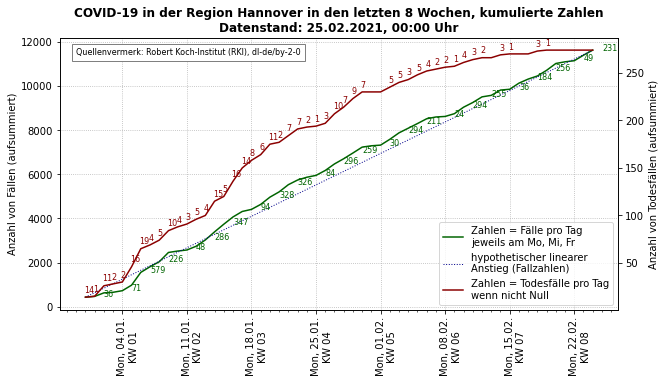

In [9]:
# calculate last xxx weeks from days; value should be dividable by 7
tagezurueck = 56
vorvierWochen = pd.to_datetime(date.today() - timedelta(tagezurueck))
piv_reg_han_subset = piv_reg_han[piv_reg_han['Meldedatum'] >= vorvierWochen].copy()
piv_reg_han_subset.drop(columns=['AnzahlFälle', 'AnzahlTodesfälle'], inplace=True)
piv_reg_han_subset[['AnzahlFälle', 'AnzahlTodesfälle']] = \
                  piv_reg_han_subset[['AnzahlFall', 'AnzahlTodesfall']].cumsum()
# define and plot both plots including a sort of trendline for the infections
fig, ax5 = plt.subplots(figsize=(10,5))
# cases
ax5.plot(piv_reg_han_subset.Meldedatum, piv_reg_han_subset.AnzahlFälle, color='darkgreen', 
         label='Zahlen = Fälle pro Tag\njeweils am Mo, Mi, Fr')
df_top_bottom = piv_reg_han_subset.iloc[[0, -1]]
ax5.plot(df_top_bottom.Meldedatum, df_top_bottom.AnzahlFälle, 
         color='darkblue', linestyle='dotted', linewidth=1,
         label='hypothetischer linearer\nAnstieg (Fallzahlen)')
# deaths
ax6 = ax5.twinx()
ax6.plot(piv_reg_han_subset.Meldedatum, piv_reg_han_subset.AnzahlTodesfälle, 
         color='darkred',
         label='Zahlen = Todesfälle pro Tag\nwenn nicht Null')
# set axis, labels, title... for all cases
ax5.autoscale(enable=True, axis='x') #, tight=True)
ax5.grid(ls=':')
ax5.tick_params(axis='x', labelrotation=90)
ax5.xaxis.set_major_formatter(mdates.DateFormatter('\n%a, %d.%m.\nKW %V'))
ax5.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax5.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax5.set_ylabel('Anzahl von Fällen (aufsummiert)')
ax5.set_title('COVID-19 in der Region Hannover in den letzten ' + \
              str(round(tagezurueck/7)) + ' Wochen, kumulierte Zahlen\nDatenstand: ' + \
              strDatenstand, weight='bold')
ax6.set_ylabel('Anzahl von Todesfällen (aufsummiert)')
# get lines and labels and create one legend for both plots
lines, labels = ax5.get_legend_handles_labels()
lines2, labels2 = ax6.get_legend_handles_labels()
ax6.legend(lines + lines2, labels + labels2, loc='lower right')
# now annotate
for index, row in piv_reg_han_subset.iterrows():
    if row['WoTag'] in ['Mon', 'Wed', 'Fri']:
        ax5.annotate(row['AnzahlFall'], xy=(row['Meldedatum'] + timedelta(hours=+24), 
                                            row['AnzahlFälle']),
                     fontsize=8, color='darkgreen')
    if row['AnzahlTodesfall'] != 0:
        ax6.annotate(row['AnzahlTodesfall'], xy=(row['Meldedatum'] + timedelta(hours=-4), 
                                                 row['AnzahlTodesfälle']+5),
                    fontsize=8, color='darkred')
# name data source
ax5.text(piv_reg_han_subset['Meldedatum'].min() - timedelta(days=1), 
         piv_reg_han_subset['AnzahlFälle'].max() - 200, 
         'Quellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0',
         ha='left', fontsize=8, bbox=dict(facecolor='white', edgecolor='grey', alpha=1))
# save and show plot
filename = 'RKI_COVID19_last' + str(round(tagezurueck/7)) + 'weeks.png'
plt.savefig(filename, dpi=100)
plt.show()
#display(piv_reg_han_subset.tail())

## Statistical Plots: Cases per Month, all Dates

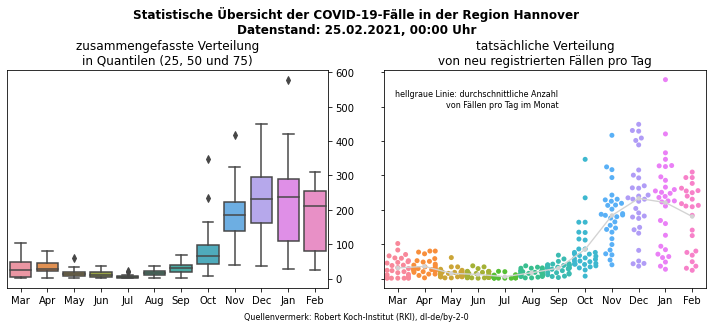

In [10]:
fig, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Statistische Übersicht der COVID-19-Fälle in der Region Hannover\nDatenstand: ' + strDatenstand, weight='bold', y=1.075)
sns.boxplot(x='Monat', y='AnzahlFall', data=piv_reg_han, ax=ax3)
sns.swarmplot(x='Monat', y='AnzahlFall', data=piv_reg_han, ax=ax4, zorder=1)
sns.pointplot(x='Monat', y='AnzahlFall', data=piv_reg_han, ci=None, color='lightgrey', scale=0.5)
ax3.set_title('zusammengefasste Verteilung\nin Quantilen (25, 50 und 75)')
ax3.yaxis.tick_right()
ax3.set_xlabel('')
ax3.set_ylabel('')
ax4.set_title('tatsächliche Verteilung\nvon neu registrierten Fällen pro Tag')
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.text(6, 500, 'hellgraue Linie: durchschnittliche Anzahl\nvon Fällen pro Tag im Monat', ha='right', fontsize=8)
fig.text(0.5,-0.01, 'Quellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0', fontsize=8, ha='center')
plt.tight_layout()
plt.savefig('RKI_COVID19_stats.png', dpi=100, bbox_inches='tight')

## Grouped Bar Plots: Cases and Deaths per Age Group

In [11]:
piv_reg_age = pd.pivot_table(df_reg_han, 
                             values=['AnzahlFall', 'AnzahlTodesfall'], 
                             index=['Meldedatum', 'Altersgruppe'], 
                             aggfunc=np.sum)
piv_reg_age[['AnzahlFälle', 'AnzahlTodesfälle']] = piv_reg_age.cumsum()
piv_reg_age.reset_index(inplace=True)
piv_reg_age['Meldedatum'] = pd.to_datetime(piv_reg_age['Meldedatum'])
#piv_reg_age['KaWo'] = piv_reg_age['Meldedatum'].dt.isocalendar().week
piv_reg_age['Jahr'] = piv_reg_age['Meldedatum'].dt.strftime('%Y')
piv_reg_age['JahrMonat'] = piv_reg_age['Meldedatum'].dt.strftime('%Y-%b')
piv_reg_age['Monat'] = piv_reg_age['Meldedatum'].dt.strftime('%b')
piv_reg_age['KaWo'] = piv_reg_age['Meldedatum'].dt.week
piv_reg_age['WoTag'] = piv_reg_age['Meldedatum'].dt.strftime('%a')
piv_reg_age.sort_values(['Altersgruppe', 'Meldedatum'], inplace=True)
display(piv_reg_age.head(2))
display(piv_reg_age.tail(2))

,Meldedatum,Altersgruppe,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
61,2020-03-24,A00-A04,1,0,392,8,2020,2020-Mar,Mar,13,Tue
72,2020-03-26,A00-A04,1,0,564,11,2020,2020-Mar,Mar,13,Thu


,Meldedatum,Altersgruppe,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
1618,2021-02-24,A80+,14,0,30897,746,2021,2021-Feb,Feb,8,Wed
1359,2021-01-11,unbekannt,3,0,21843,563,2021,2021-Jan,Jan,2,Mon


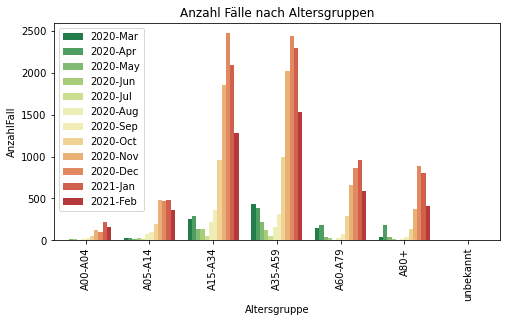

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(x='Altersgruppe', y='AnzahlFall', hue='JahrMonat', data=piv_reg_age,
            #hue_order=['A00-A04', 'A05-A14', 'A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
           palette='RdYlGn_r', ci=None, estimator=sum)
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Anzahl Fälle nach Altersgruppen');

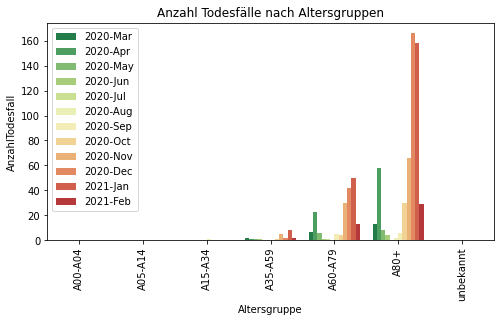

In [13]:
plt.figure(figsize=(8,4))
sns.barplot(x='Altersgruppe', y='AnzahlTodesfall', hue='JahrMonat', data=piv_reg_age,
           palette='RdYlGn_r', ci=None, estimator=sum)
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Anzahl Todesfälle nach Altersgruppen');

## Grouped Bar Plots: Cases and Deaths per Gender

In [14]:
piv_reg_mf = pd.pivot_table(df_reg_han, 
                             values=['AnzahlFall', 'AnzahlTodesfall'], 
                             index=['Meldedatum', 'Geschlecht'], 
                             aggfunc=np.sum)
piv_reg_mf[['AnzahlFälle', 'AnzahlTodesfälle']] = piv_reg_mf.cumsum()
piv_reg_mf.reset_index(inplace=True)
piv_reg_mf['Meldedatum'] = pd.to_datetime(piv_reg_mf['Meldedatum'])
piv_reg_mf['Jahr'] = piv_reg_mf['Meldedatum'].dt.strftime('%Y')
piv_reg_mf['JahrMonat'] = piv_reg_mf['Meldedatum'].dt.strftime('%Y-%b')
piv_reg_mf['Monat'] = piv_reg_mf['Meldedatum'].dt.strftime('%b')
piv_reg_mf['KaWo'] = piv_reg_mf['Meldedatum'].dt.week
piv_reg_mf['WoTag'] = piv_reg_mf['Meldedatum'].dt.strftime('%a')
piv_reg_mf.sort_values(['Geschlecht', 'Meldedatum'], inplace=True)
display(piv_reg_mf.head(2))
display(piv_reg_mf.tail(2))

,Meldedatum,Geschlecht,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
0,2020-03-01,M,1,0,1,0,2020,2020-Mar,Mar,9,Sun
1,2020-03-03,M,1,0,2,0,2020,2020-Mar,Mar,10,Tue


,Meldedatum,Geschlecht,AnzahlFall,AnzahlTodesfall,AnzahlFälle,AnzahlTodesfälle,Jahr,JahrMonat,Monat,KaWo,WoTag
871,2021-02-23,unbekannt,5,0,30666,746,2021,2021-Feb,Feb,8,Tue
874,2021-02-24,unbekannt,2,0,30897,746,2021,2021-Feb,Feb,8,Wed


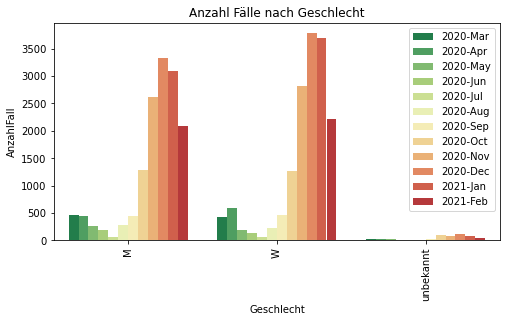

In [15]:
plt.figure(figsize=(8,4))
sns.barplot(x='Geschlecht', y='AnzahlFall', hue='JahrMonat', data=piv_reg_mf,
            #hue_order=['A00-A04', 'A05-A14', 'A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
           palette='RdYlGn_r', ci=None, estimator=sum)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Anzahl Fälle nach Geschlecht');

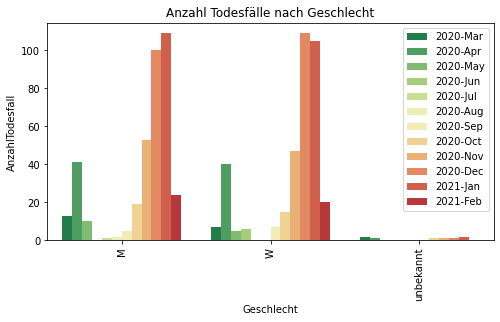

In [16]:
plt.figure(figsize=(8,4))
sns.barplot(x='Geschlecht', y='AnzahlTodesfall', hue='JahrMonat', data=piv_reg_mf,
            #hue_order=['A00-A04', 'A05-A14', 'A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
           palette='RdYlGn_r', ci=None, estimator=sum)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Anzahl Todesfälle nach Geschlecht');

# Playing Around: Other Plot Types for Case Numbers

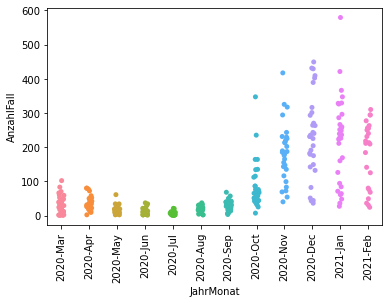

In [17]:
sns.stripplot(x='JahrMonat', y='AnzahlFall', data=piv_reg_han)
plt.xticks(rotation=90);

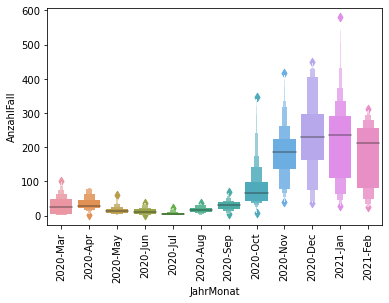

In [18]:
sns.boxenplot(x='JahrMonat', y='AnzahlFall', data=piv_reg_han)
plt.xticks(rotation=90);

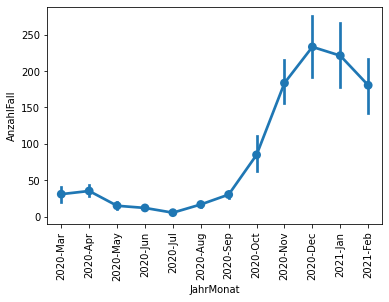

In [19]:
sns.pointplot(x='JahrMonat', y='AnzahlFall', data=piv_reg_han)
plt.xticks(rotation=90);

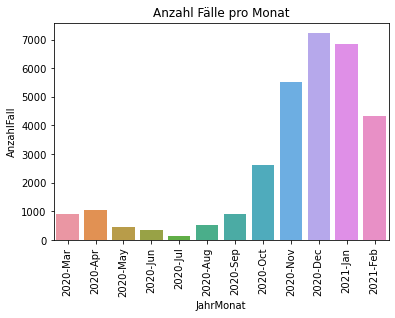

In [20]:
sns.barplot(x='JahrMonat', y='AnzahlFall', data=piv_reg_han,
           ci=None, estimator=sum)
plt.xticks(rotation=90)
plt.title('Anzahl Fälle pro Monat');

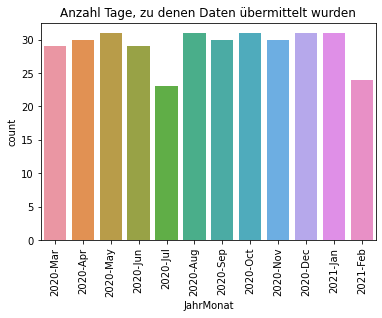

In [21]:
sns.countplot(x='JahrMonat', data=piv_reg_han)
plt.xticks(rotation=90)
plt.title('Anzahl Tage, zu denen Daten übermittelt wurden');